In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2\

import networkx as nx
import numpy as np

from TCGAMultiOmics.multiomics import MultiOmicsData
from moge.network.heterogeneous_network import HeterogeneousNetwork

from moge.visualization.plot_data import matrix_heatmap

#  Import network from file

In [2]:
import pickle

# READ
with open('moge/data/mirtarbase_lnc-mi/lmn_corr_weighted_node05_d_u_un_train.pickle', 'rb') as file:
# with open('moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_network_biogrid.pickle', 'rb') as file:
    network = pickle.load(file)
#     network.remove_extra_nodes()
#     network.node_list = network.all_nodes
#     node_list = network.node_list

nan_nodes = [n for n in network.G.nodes if type(n) != str]
network.G.remove_nodes_from(nan_nodes)
# network.G.number_of_edges()

In [3]:
# READ edgelists
with open('moge/data/mirtarbase_lnc-mi/lmn_corr_weighted_node05_d_u_un_test.pickle', 'rb') as file:
    network_test = pickle.load(file)
    
with open('moge/data/mirtarbase_lnc-mi/lmn_corr_weighted_node05_d_u_un_val.pickle', 'rb') as file:
    network_val = pickle.load(file)

# print("network_test", network_test.G.number_of_edges())
# print("network_val", network_val.G.number_of_edges())

In [4]:
isolates = nx.isolates(network.G)
len([n for n in isolates])

0

# Data Visualization

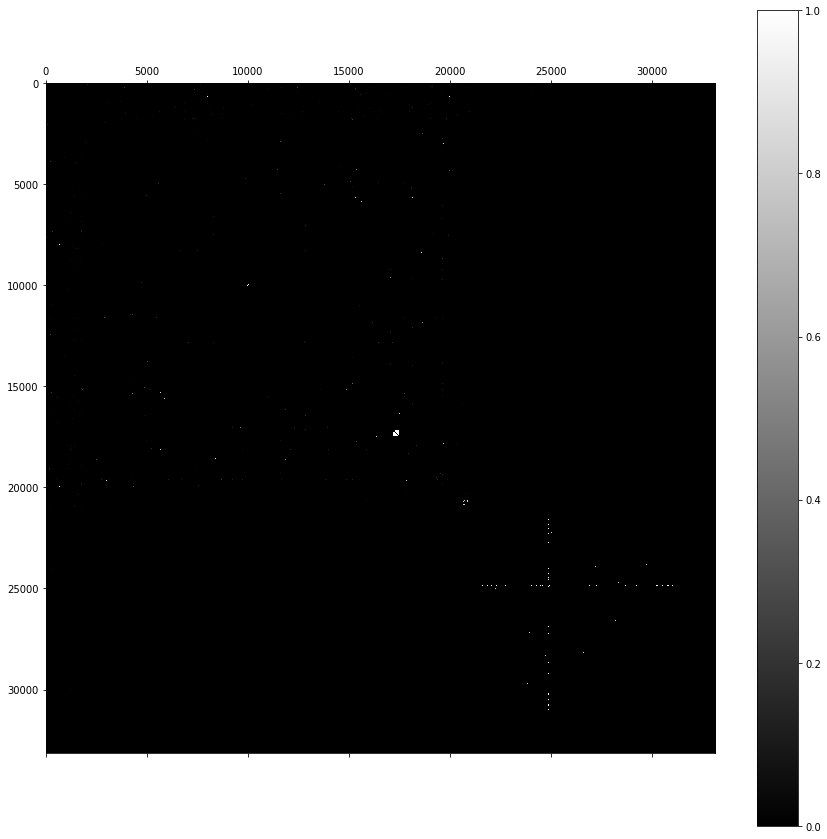

In [7]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["d", 'u'], node_list=network.node_list).todense())

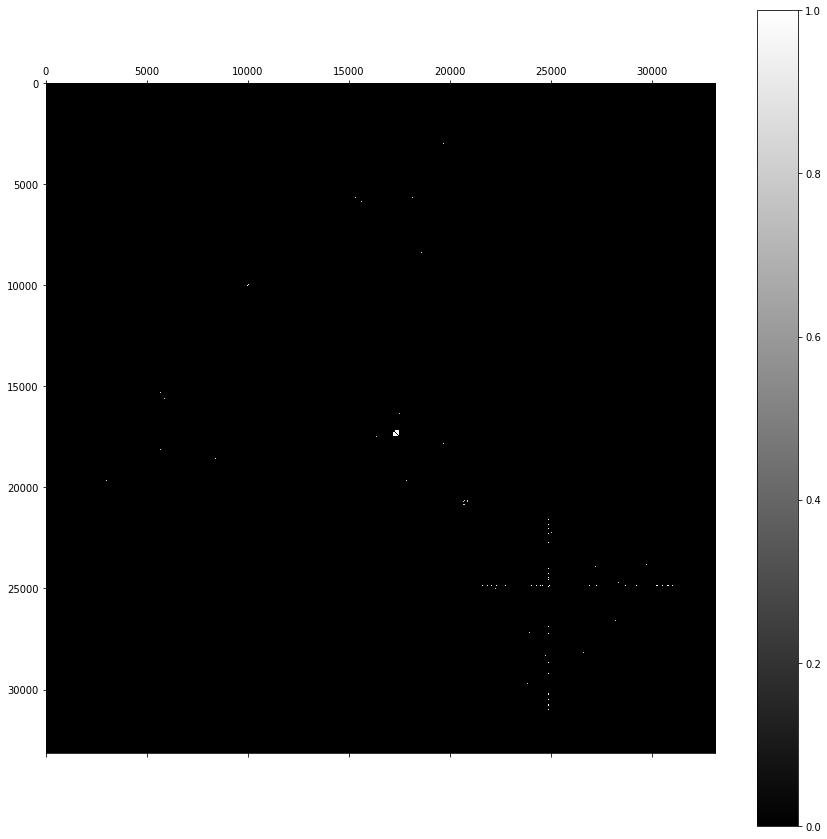

In [5]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.node_list).todense())

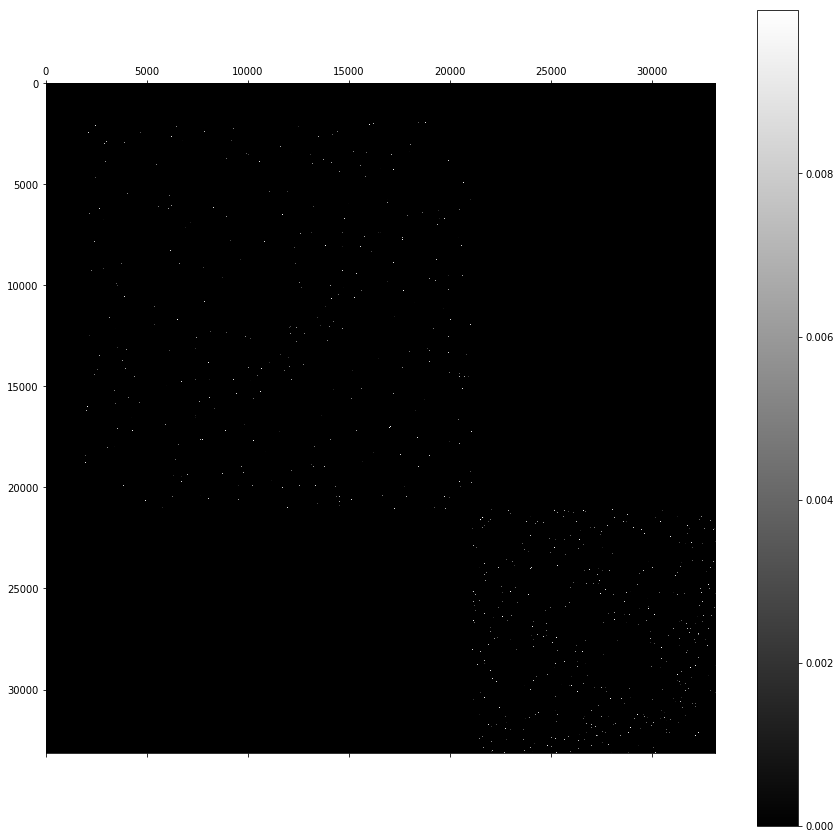

In [6]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u_n"], node_list=network.node_list).todense())

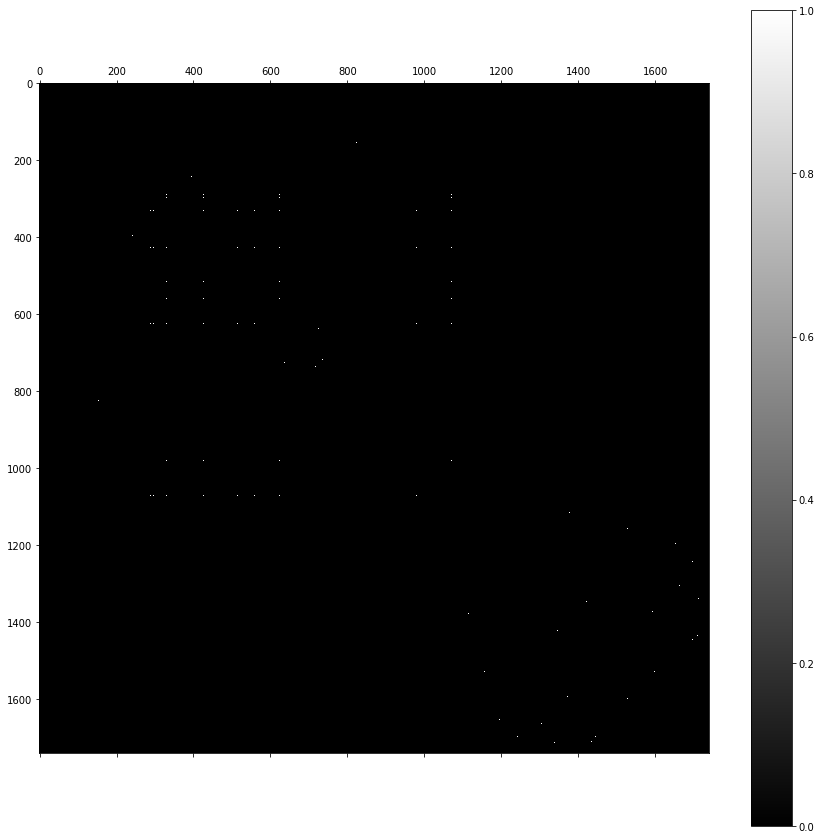

In [9]:
# The test data to recall
matrix_heatmap(network_val.get_adjacency_matrix(edge_types=["u"], node_list=network_val.node_list).todense())

# Train

In [10]:
from moge.embedding.siamese_graph_embedding import SiameseGraphEmbedding

siamese = SiameseGraphEmbedding(d=512, batch_size=4096, lr=0.001, epochs=20, negative_sampling_ratio=5.0,
                                 max_length=700, truncating="random", verbose=True)

Using TensorFlow backend.


In [ ]:
siamese.learn_embedding(network, network_val=network_val, multi_gpu=True, seed=0)

Genes info columns: ['locus_type', 'location', 'Family', 'Transcript sequence', 'Disease association', 'Transcript length']
Number of nodes without seq removed: 831
num_words: None {'A': 1, 'T': 2, 'G': 3, 'C': 4, 'U': 5}
Ed_count: 564767 , Eu_count: 205842 , En_count: 1117265
Ens_count: 2823835
Genes info columns: ['locus_type', 'location', 'Family', 'Transcript sequence', 'Disease association', 'Transcript length']
Number of nodes without seq removed: -30566
num_words: None {'A': 1, 'T': 2, 'G': 3, 'C': 4, 'U': 5}
Ed_count: 33251 , Eu_count: 9391 , En_count: 62228
Ens_count: 33251
conv1d_1 Tensor("conv1d_1/Relu:0", shape=(?, ?, 192), dtype=float32, device=/device:CPU:0)
max pooling_1 Tensor("max_pooling1d_1/Squeeze:0", shape=(?, ?, 192), dtype=float32, device=/device:CPU:0)
conv1d_2 Tensor("conv1d_2/Relu:0", shape=(?, ?, 320), dtype=float32, device=/device:CPU:0)
max pooling_2 Tensor("max_pooling1d_2/Squeeze:0", shape=(?, ?, 320), dtype=float32, device=/device:CPU:0)
brnn Tensor("bid

# Visualize Embeddings

In [ ]:
matrix_heatmap(siamese.get_embedding(), aspect='auto')

Embeddings filtered by node list (30695, 512)


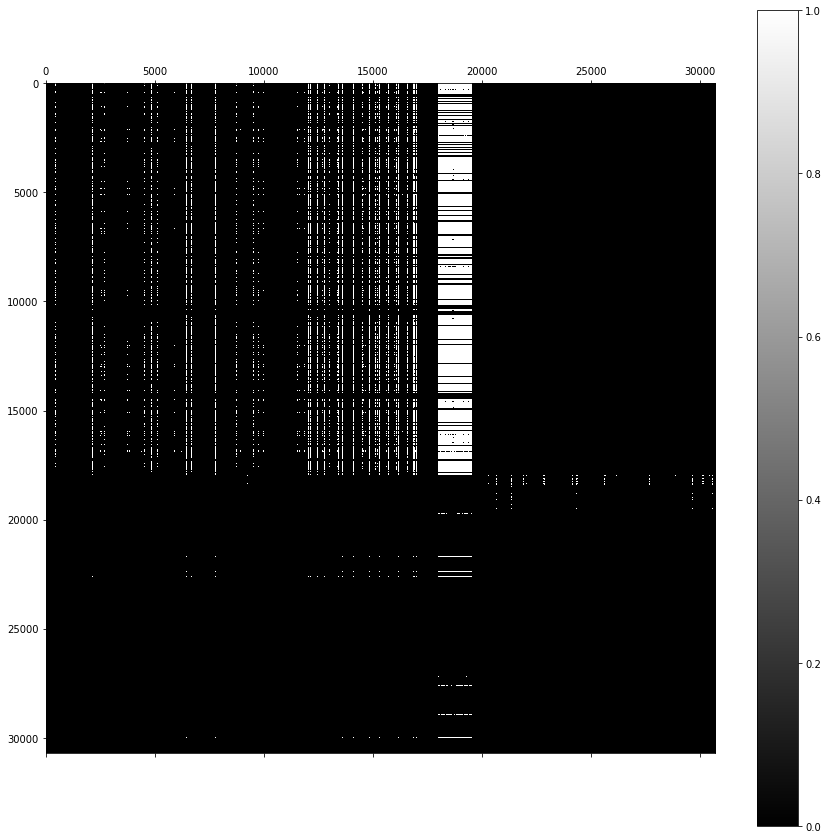

In [22]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="d", node_l=network.node_list))

Embeddings filtered by node list (1612, 512)


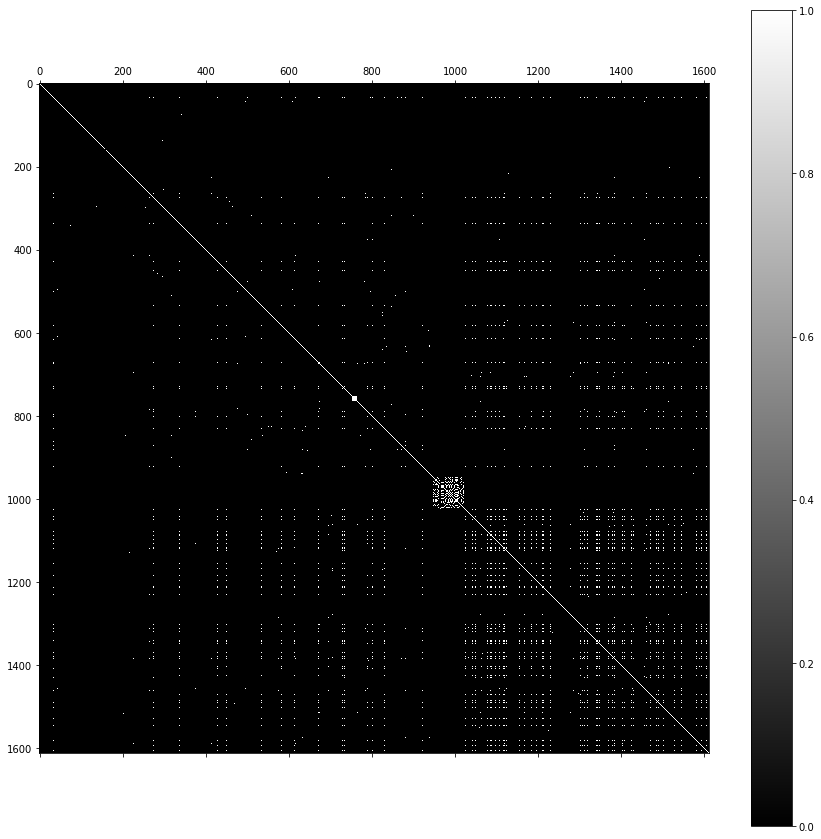

In [26]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="u", node_l=network_val.node_list))

# Plot measures on training and testing

In [28]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc_roc', 'loss', 'accuracy', 'precision', 'recall', 'auc_roc'])

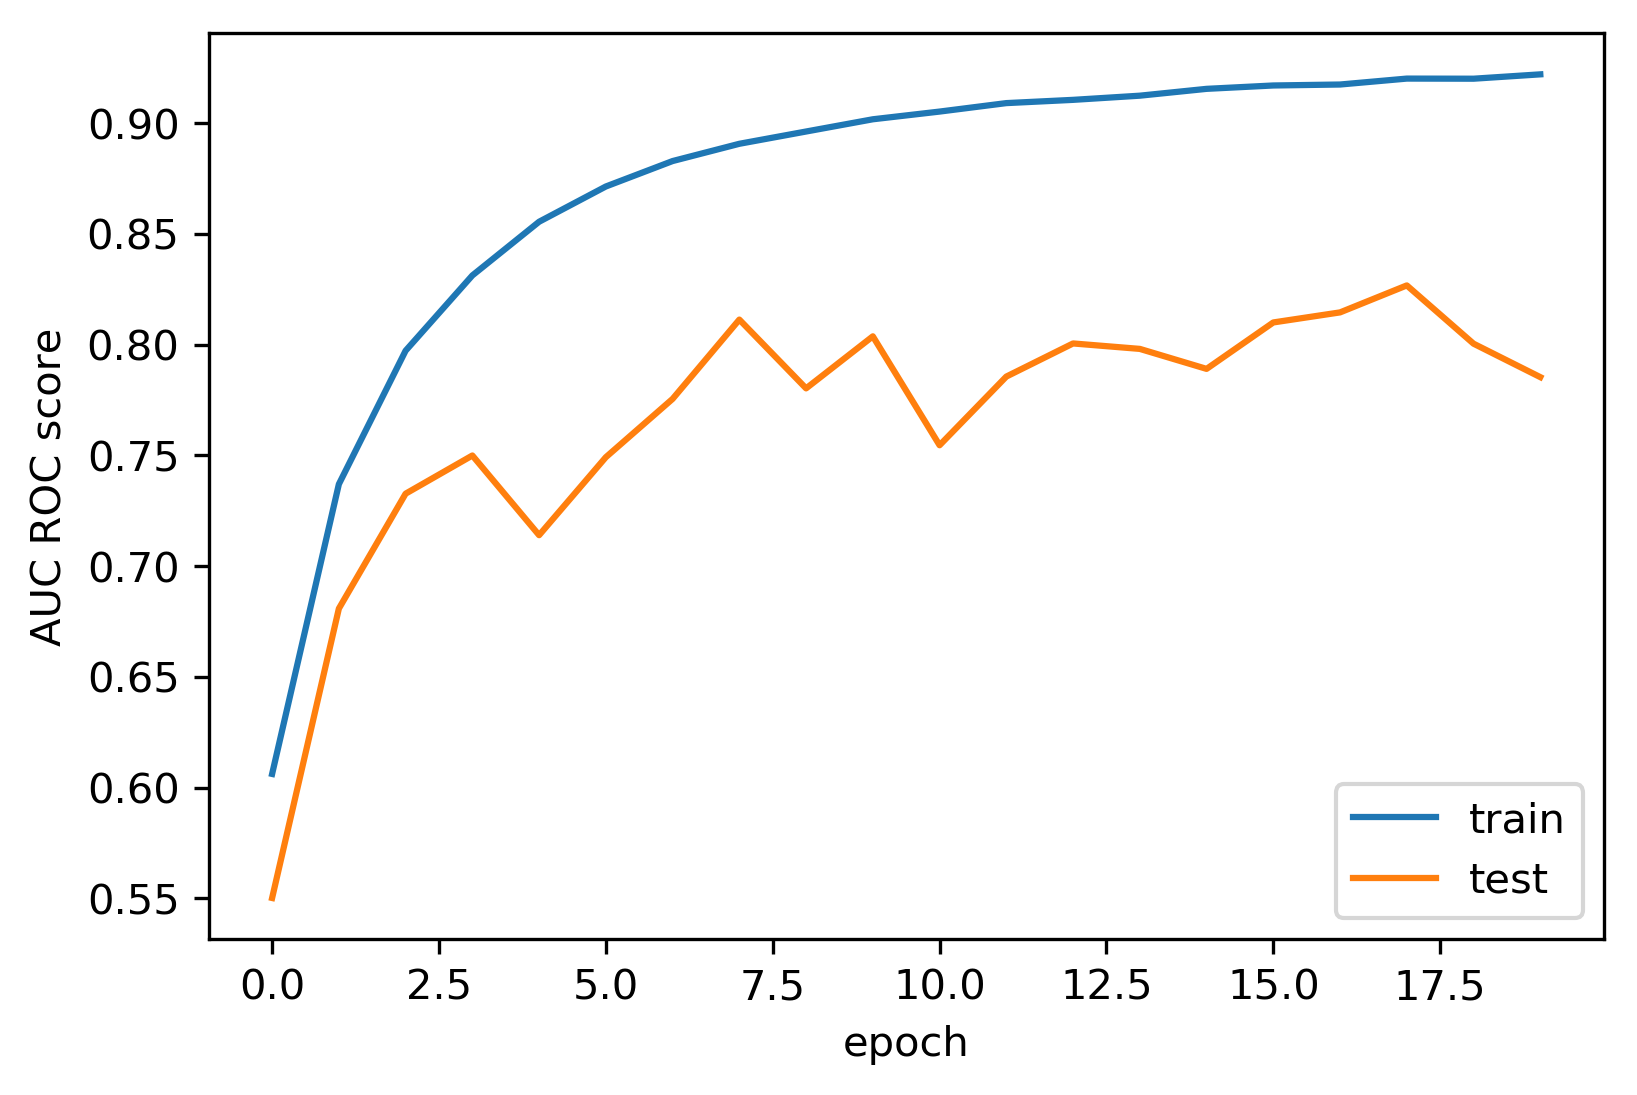

In [34]:
import matplotlib.pyplot as plt
history = siamese.history
plt.figure(dpi=300)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
# plt.title('Link prediction performance')
plt.ylabel('AUC ROC score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# Save Model

In [25]:
siamese.lstm_network.save("moge/data/mirtarbase_lnc-mi/models/lstm_512_nodes_randtrunc_weighted_e20.h5")

In [ ]:
siamese_net.summary()

In [ ]:
lstm_network.summary()

# Evaluate on test data

In [40]:
from moge.network.data_generator import DataGenerator
negative_sampling_ratio = 1.0
generator_Ed = DataGenerator(network=network_val, negative_sampling_ratio=negative_sampling_ratio,
                          maxlen=siamese.max_length, padding='post', truncating="post",
                          batch_size=siamese.batch_size, dim=siamese.input_shape, 
                          shuffle=True, seed=0)
generator_Ed.Eu_count = 0
generator_Ed.En_count = 0
generator_Ed.on_epoch_end()
# Ed_count: 72811 , Eu_count: 141062 , En_count: 130530, Ens_count: 145622
generator_Ed.Ed_count, generator_Ed.En_count, generator_Ed.Eu_count, generator_Ed.Ens_count

Genes info columns: ['locus_type', 'location', 'Family', 'Transcript sequence', 'Disease association', 'Transcript length']
Number of nodes without seq removed: -30568
num_words: None {'A': 1, 'T': 2, 'G': 3, 'C': 4, 'U': 5}
Ed_count: 31779 , Eu_count: 11369 , En_count: 44750
Ens_count: 31779


(31779, 0, 0, 31779)

In [41]:
generator_Eu = DataGenerator(network=network_val, negative_sampling_ratio=negative_sampling_ratio,
                          maxlen=siamese.max_length, padding='post', truncating="post",
                          batch_size=siamese.batch_size, dim=siamese.input_shape, 
                          shuffle=True, seed=0)
generator_Eu.Ed_count = 0
generator_Eu.Ens_count = 0
generator_Eu.on_epoch_end()
generator_Eu.Ed_count, generator_Eu.En_count, generator_Eu.Eu_count, generator_Eu.Ens_count

Genes info columns: ['locus_type', 'location', 'Family', 'Transcript sequence', 'Disease association', 'Transcript length']
Number of nodes without seq removed: -30568
num_words: None {'A': 1, 'T': 2, 'G': 3, 'C': 4, 'U': 5}
Ed_count: 31779 , Eu_count: 11369 , En_count: 44750
Ens_count: 31779


(0, 44750, 11369, 0)

In [32]:
siamese.siamese_net.metrics_names

['loss', 'accuracy', 'precision', 'recall', 'auc_roc']

In [42]:
siamese.siamese_net.evaluate_generator(generator_Ed, use_multiprocessing=True, workers=8)

[0.21972447633743286,
 0.7129603794642857,
 0.9527841210365295,
 0.4510765160833086,
 0.9380247082029071]

In [43]:
siamese.siamese_net.evaluate_generator(generator_Eu, use_multiprocessing=True, workers=8)

[0.15404596810157484,
 0.8253455528846154,
 0.6789519236637995,
 0.25810594054368824,
 0.9377987017998328]

# AUC Rate

In [42]:
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

In [ ]:
y = []
for i in generator_test.indexes:
    _, y_i = generator_test.__getitem__(i)
    y.append(y_i)

y_true = np.array(y)
y_true=y_true.reshape(y_true.shape[0], y_true.shape[-1])
y_true.shape

In [125]:
y_pred_keras = siamese_net.predict_generator(generator_test)
y_pred_keras.shape
# fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
# auc_keras = auc(fpr_keras, tpr_keras)

InternalError: CUB segmented reduce errorinvalid configuration argument
	 [[Node: replica_0/model_2/model_1/bidirectional_1/Sum = Sum[T=DT_FLOAT, Tidx=DT_INT32, keep_dims=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](replica_0/model_2/model_1/bidirectional_1/zeros_like, replica_0/model_2/model_1/bidirectional_1/Sum/reduction_indices)]]
	 [[Node: replica_3/model_2/lambda_1/Sqrt/_2299 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:3", send_device_incarnation=1, tensor_name="edge_4300_replica_3/model_2/lambda_1/Sqrt", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [ ]:
tf.nn.in_top_k(
    predictions=y_pred,
    targets=y_true,
    k=1000).eval()

In [ ]:
%%javascript
Jupyter.notebook.session.delete();